# Lab 1 - A*

An implementation of the A* search algorithm ideated and programmed by **Claudio Savelli (s)** & **Mattia Sabato (s305849)** during a cold and rainy October. We have designed the algorithm in order to not only reach the goal in the **fastest way** but also in a **smart way**. We achieve this by reducing the number of overlappings and by forcing a solution which has the less number of shared points in the sets considered.

In [29]:
from random import random
from functools import reduce
from collections import namedtuple, deque
from queue import PriorityQueue, SimpleQueue, LifoQueue
from time import time
from math import ceil
from tqdm.auto import tqdm

import numpy as np

In [2]:
# Set the configuration of the problem.
PROBLEM_SIZE = 27    # Number of points to be covered.
NUM_SETS = 100       # Number of sets in our pool.
ALPHA = 0.5         # Probability for a set to cover one point.

State = namedtuple('State', ['taken', 'not_taken'])

SETS = tuple(np.array([random() < ALPHA for _ in range(PROBLEM_SIZE)]) \
                for _ in range (NUM_SETS))


In [3]:
def goal_check(state: namedtuple) -> bool:
    '''
    Checks whether the problem is solvable and return `False` if not.
    '''
    return np.all(reduce(np.logical_or, [SETS[i] for i in state.taken], \
                         np.array([False for _ in range(PROBLEM_SIZE)])))


def proximity(state: namedtuple) -> int:
    '''
    Computes the proximity between a candidate state and the goal by
    summing the updated number of covered points.
    '''
    return sum(reduce(np.logical_or, [SETS[i] for i in state.taken],
               np.array([False for _ in range(PROBLEM_SIZE)])))


def cost(state) -> float:
    '''
    Computes the cost associated to a candidate state by summing the
    overlappings over the same point.
    '''
    if len(state.taken) == 0:
        return 0
    else:
        return sum(np.array([SETS[i] for i in state.taken]).sum(axis = 0))

def count_overlaps(state) -> int:
    temp = cost(state)
    return temp - PROBLEM_SIZE

assert goal_check(State(set(range(NUM_SETS)), set())), 'Problem not solvable'

In [4]:
frontier = PriorityQueue() 
# frontier = SimpleQueue()
# frontier = LifoQueue()

state = State(set(), set(range(NUM_SETS)))
frontier.put((proximity(state), state))

counter = 0
_, current_state = frontier.get()

tic = time()
while not goal_check(current_state): 

    counter += 1

    for action in current_state.not_taken:

        new_state = State(current_state.taken ^ {action}, \
                          current_state.not_taken ^ {action})
        frontier.put((cost(new_state) - proximity(new_state), new_state))
    
    _, current_state = frontier.get()
    
toc = time()

print(f'Solved in {counter:,} steps ({len(current_state.taken)} tiles) \
in {(toc - tic)*1000:.0f}ms')
print(current_state)

Solved in 4,418 steps (3 tiles) in 19871ms
State(taken={49, 30, 63}, not_taken={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99})


In [5]:
for state in current_state.taken:
    print(SETS[state])

count_overlaps(current_state)

[False  True False False  True False False  True  True  True False  True
 False  True False False False False False  True False  True False False
 False False  True]
[ True False  True  True False False False  True False False  True False
  True False  True  True  True  True False  True  True False  True False
 False False False]
[ True False False  True False  True  True False False False False False
 False False False  True False  True  True  True False False False  True
  True  True False]


7

## Comparison with professor's solution implementing our cost function

In [6]:
def covered(state):
    return reduce(
        np.logical_or,
        [SETS[i] for i in state.taken],
        np.array([False for _ in range(PROBLEM_SIZE)]),
    )

def h(state):
    largest_set_size = max(sum(s) for s in SETS)
    missing_size = PROBLEM_SIZE - sum(covered(state))
    optimistic_estimate = ceil(missing_size / largest_set_size)
    return optimistic_estimate


def h2(state):
    already_covered = covered(state)
    if np.all(already_covered):
        return 0
    largest_set_size = max(sum(np.logical_and(s, np.logical_not(already_covered))) for s in SETS)
    missing_size = PROBLEM_SIZE - sum(already_covered)
    optimistic_estimate = ceil(missing_size / largest_set_size)
    return optimistic_estimate


def h3(state):
    already_covered = covered(state)
    if np.all(already_covered):
        return 0
    missing_size = PROBLEM_SIZE - sum(already_covered)
    candidates = sorted((sum(np.logical_and(s, np.logical_not(already_covered))) for s in SETS), reverse=True)
    taken = 1
    while sum(candidates[:taken]) < missing_size:
        taken += 1
    return taken


def f(state, h: str = 'h3'):
    if h == 'h':
        return len(state.taken) + h(state)
    elif h == 'h2':
        return len(state.taken) + h2(state)
    elif h == 'h3':
        return len(state.taken) + h3(state)

In [7]:
frontier = PriorityQueue() 

state = State(set(), set(range(NUM_SETS)))
frontier.put((f(state), state))

counter = 0
_, current_state_prof = frontier.get()

tic = time()
while not goal_check(current_state_prof): 

    counter += 1

    for action in current_state_prof.not_taken:

        new_state = State(current_state_prof.taken ^ {action}, \
                          current_state_prof.not_taken ^ {action})
        frontier.put((f(new_state), new_state))
    
    _, current_state_prof = frontier.get()
    
toc = time()

print(f'Solved in {counter:,} steps ({len(current_state_prof.taken)} tiles) \
in {(toc - tic)*1000:.0f}ms')
print(current_state_prof)

Solved in 26 steps (3 tiles) in 1411ms
State(taken={2, 69, 54}, not_taken={0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99})


In [8]:
for state in current_state_prof.taken:
    print(SETS[state])

count_overlaps(current_state_prof)

[ True False False False  True  True  True False False False False  True
  True  True False  True  True  True  True  True False False False  True
  True False  True]
[False  True  True  True  True False  True  True  True  True False False
  True  True  True  True False  True False  True False  True  True  True
 False  True  True]
[ True  True False  True  True False  True False False False  True  True
  True False  True  True False False False  True  True False  True False
 False False  True]


21

## Plot of the results 

Thanks to Beatrice Occhiena for the plot and the nice idea! 

In [18]:
print(type(current_state_prof))

def take_state_from_set(state: set): 
    res = []
    for elem in state:
        res.append(SETS[elem])
    return res

<class '__main__.State'>


3

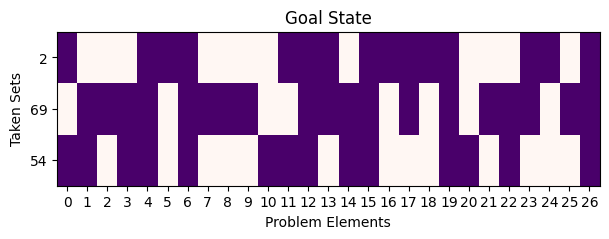

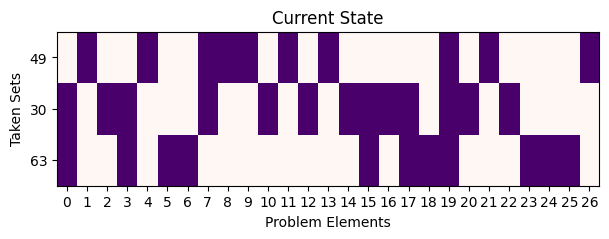

In [21]:
import matplotlib.pyplot as plt

# plot the solution    
def visualize_state_ordered(state, is_goal=False):
    taken_sets = state.taken

    plt.figure(figsize=(7, 2))
    plt.imshow(take_state_from_set(state.taken), cmap='RdPu', aspect='auto')
    plt.title("Current State" if not is_goal else "Goal State")
    plt.xlabel("Problem Elements")
    plt.xticks(np.arange(PROBLEM_SIZE))
    plt.ylabel("Taken Sets")
    # on the ticks of the y axis, show the indices of the taken sets
    plt.yticks(np.arange(len(taken_sets)), list(taken_sets))
    plt.show()

visualize_state_ordered(current_state_prof, is_goal=True)
visualize_state_ordered(current_state, is_goal=False)

# We won!

# Additional experiments

## Depth First Search

In [30]:
frontier = deque()
state = State(set(), set(range(NUM_SETS)))
frontier.append(state)

counter = 0
current_state_dfs = frontier.pop()
with tqdm(total=None) as pbar:
    while not goal_check(current_state_dfs):
        counter += 1
        for action in current_state_dfs[1]:
            new_state = State(
                current_state_dfs.taken ^ {action},
                current_state_dfs.not_taken ^ {action},
            )
            frontier.append(new_state)
        current_state_dfs = frontier.pop()
        pbar.update(1)

print(f"Solved in {counter:,} steps ({len(current_state_dfs.taken)} tiles)")

6it [00:00, 1310.79it/s]

Solved in 6 steps (6 tiles)


In [31]:
for state in current_state_dfs.taken:
    print(SETS[state])

count_overlaps(current_state_dfs)

[ True  True  True False  True False False False False False  True  True
  True False False  True False False  True False False  True  True False
  True  True False]
[False  True  True False  True False  True  True  True False False  True
  True  True False False False False  True False  True False False  True
 False  True False]
[False  True  True  True  True False  True  True False  True  True  True
 False False False False  True  True  True False False False  True False
 False False False]
[False  True False  True False  True  True False False False  True  True
 False  True  True  True False  True  True False False False  True False
  True  True False]
[False False False  True False False  True  True  True  True False  True
  True False False  True False  True False  True  True False False  True
 False  True  True]
[False  True  True False False False  True False False False  True  True
 False False False False False  True  True  True False False False  True
 False  True False]


50

## Greedy Best First

In [33]:
def old_f(state):
    missing_size = PROBLEM_SIZE - sum(covered(state))
    return missing_size

In [34]:
frontier = PriorityQueue()
state = State(set(), set(range(NUM_SETS)))
frontier.put((old_f(state), state))

counter = 0
_, current_state_gbf = frontier.get()
with tqdm(total=None) as pbar:
    while not goal_check(current_state_gbf):
        counter += 1
        for action in current_state_gbf[1]:
            new_state = State(
                current_state_gbf.taken ^ {action},
                current_state_gbf.not_taken ^ {action},
            )
            frontier.put((old_f(new_state), new_state))
        _, current_state_gbf = frontier.get()
        pbar.update(1)

print(f"Solved in {counter:,} steps ({len(current_state_gbf.taken)} tiles)")

3it [00:00, 500.22it/s]

Solved in 3 steps (3 tiles)


In [35]:
for state in current_state_gbf.taken:
    print(SETS[state])

count_overlaps(current_state_gbf)

[False  True  True False  True False  True  True  True False False  True
  True  True False  True  True  True False  True  True False False  True
  True  True  True]
[ True  True  True  True  True  True  True False False False  True False
  True False False  True  True  True  True False  True  True  True  True
 False  True  True]
[False False  True False  True False  True  True  True  True False  True
  True False  True  True  True False  True  True False  True False  True
  True False  True]


27